In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import numpy as np
import re
import time
import random
import io
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Data Gathering: Scraping the Web for Matchups

This shows how we gathered the information used in the following models. The main function calls for these have been commented out to avoid scraping the data again. Feel free to run on a small scale, to see how they work!

If "All Matchup Score.csv" and "NFL Historical Data.csv" have not all been imported, then these cells may be used to create the datasets used for the rest of the code.

In [5]:


# NFL Historical Data Scraper Functions
def single_season(season):
  dflist = []
  modes = ["offense","defense","special-teams"]
  #List of all possible options
  alloptions = [["passing","rushing","receiving","scoring","downs"],["passing","rushing","receiving","scoring","tackles","downs","interceptions"] \
             ,["field-goals","scoring","kickoffs","kickoff-returns","punts","punt-returns"]]

  for i in range(len(modes)):
    mode = modes[i]
    options = alloptions[i]
    for j in range(len(options)):
      option = options[j]
      print(f"Gathering {mode} {option} data for {season}...")
      url = f"https://www.nfl.com/stats/team-stats/offense/{option}/{season}/reg/all"
      page = requests.get(url)
      contents = page.content
      soup = BeautifulSoup(contents,"html.parser")
      tables = soup.find_all("table")
      if len(str(tables)) == 0:
          print("This is gonna be a problem")
      df = pd.read_html(io.StringIO(str(tables)))[0]
      year = np.ones(len(df)) * season
      df.insert(loc = 0, column = "Year", value = year)
      df["Year"] = df["Year"].astype(int)

      teams = df["Team"]
      correctedteams = []
      for team in teams:
        correctedteams.append(team.split(" ")[0])
      df["Team"] = correctedteams

      dfheadings = list(df)[2:]
      newheadings = []
      headingdict = {}
      for heading in dfheadings:
        newheading = mode+" "+option+" "+heading
        newheadings.append(newheading)
      for j in range(len(newheadings)):
        headingdict[dfheadings[j]] = newheadings[j]
      df.rename(columns = headingdict,inplace=True)

      dflist.append(df)
  return dflist

class NFLData:
  def __init__(self,start,end):
    self.start = start
    self.end = end
    self.dflist = []
    self.df = pd.DataFrame()
  def pull_all(self):
    log = self.start
    if self.dflist != []:
      print("Data already collected.")
      return
    #Pulls the next years data and adds it onto each pulled table
    while (log <= self.end):
      dfs = single_season(log)
      if dfs == 1:
          print("Data not present")
          return None
          break
      if not self.dflist or len(self.dflist) == 0:
        newdflist = dfs
      else:
        newdflist = []
        for i in range(len(self.dflist)):
          if dfs:
            onedf = dfs[i]
            twodf = self.dflist[i]
            newdf = pd.concat([onedf,twodf])
            newdflist.append(newdf)
      self.dflist = newdflist
      log+=1
  def to_one_df(self):
    print("Merging to one DataFrame...")
    df1 = self.dflist[0]
    df2 = self.dflist[1]
    common_columns = ['Team', 'Year']  # Specify common columns
    # Merge the first two dataframes
    combined_df = pd.merge(df1, df2, on=common_columns, how='inner')
    for df in self.dflist[2:]:
      combined_df = pd.merge(combined_df,df,on=common_columns,how="inner")
    self.__df = combined_df
    print("Merge Complete!")
  def append(self,df):
      print("Appending analysis to DataFrame...")
      self.__df = pd.concat((self.__df,df))
  def display(self):
    if len(self.__df) > 0:
      return self.__df
    else:
      raise ValueError("No DataFrame to Display")
      return
  def save(self,name):
    if len(self.__df) == 0:
      raise ValueError("No DataFrame to Save")
      return
    self.df.to_csv(name)

#Function that will automatically update the player_data df if it sees the df isn't fully updated
def update_player_data(df):
    #See what years are in the highest table
    highest_current_year = df["Year"].max()

    desired_years = datetime.date.today().year - 1
    #If the dataset is not as updated as possible...
    if desired_years > highest_current_year:
        #Starts a datascraping object to grab all needed years
        NewData = NFLData(highest_current_year + 1,desired_years)
        #scrapes relevant years
        NewData.pull_all()
        #Combines dflist in Newdata to one dataframe
        NewData.to_one_df()
        #Adds existing data to NewData object
        NewData.append(df)
        NewData.save("DataSets/NFL Historical Data.csv")
        print("player_data DataFrame up to date!")
        return NewData.display()
    else:
        print("player_data DataFrame up to date!")
        return df
  
#Example Function Calls for complete data reboot (unecessary, as csv is already included)
#test_df = NFLData(2023,2023)
#test_df.pull_all()
#test_df.to_one_df()
#test_df.display()


player_data = pd.read_csv(r".\NFL Historical Data.csv")
#Ensures that player data is up to date, scrapes data and pushes changes to csv if triggerred
update_player_data(player_data)



player_data DataFrame up to date!


,Unnamed: 0,Year,Team,offense passing Att,offense passing Cmp,offense passing Cmp %,offense passing Yds/Att,offense passing Pass Yds,offense passing TD,offense passing INT,...,special-teams punts P Blk,special-teams punt-returns Avg,special-teams punt-returns Ret,special-teams punt-returns Yds,special-teams punt-returns PRet T,special-teams punt-returns 20+,special-teams punt-returns 40+,special-teams punt-returns FC,special-teams punt-returns FUM,special-teams punt-returns P Blk
0,0,2023,Commanders,636,407,64.0,6.6,4174,24,21,...,2,7.9,35,278,0,3,1,14,2,0
1,1,2023,Chiefs,635,421,66.3,6.9,4383,28,17,...,0,9.3,41,380,0,7,1,17,5,0
2,2,2023,Chargers,632,409,64.7,6.8,4312,24,8,...,0,16.0,24,385,1,6,1,29,3,0
3,3,2023,Vikings,631,424,67.2,7.4,4700,30,19,...,0,7.8,37,289,0,3,0,14,1,0
4,4,2023,Browns,624,355,56.9,6.4,4011,24,23,...,0,8.4,41,343,0,1,0,36,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,1600,1970,Bengals,339,172,50.7,6.2,2097,12,11,...,0,8.8,37,327,1,0,0,28,0,1
1601,1601,1970,Dolphins,299,159,53.2,7.6,2284,15,19,...,0,9.8,30,295,1,0,0,15,0,0
1602,1602,1970,Cowboys,297,149,50.2,8.2,2445,18,16,...,1,7.4,32,237,0,0,0,17,0,1
1603,1603,1970,Lions,294,167,56.8,7.2,2121,19,12,...,1,9.0,34,306,1,0,0,14,0,1


In [6]:
# Matchup Scraper functions
def get_team_name(s):
  if type(s) != str:
    raise ValueError("Team must be string")
    return
  if " " not in s:
    raise ValueError("Team must contain a space")
    return

  arr = s.split(" ")
  return arr[len(arr)-1]
def grab_one_season(year):
  url = f"https://www.pro-football-reference.com/years/{year}/games.htm"
  page = requests.get(url)
  contents = page.content
  soup = BeautifulSoup(contents,"html.parser")
  tables = soup.find_all("table")
  #Don't know if this line is necessary in GitHub
  time.sleep(5)

  df = line_score = pd.read_html(io.StringIO(str(tables[0])))[0]
  years = [year] * len(df)
  df["Year"] = years
  df.set_index("Week",inplace=True)
  df = df[(df["Day"] != "Day") & (df["Date"] != "Playoffs")]
  for col in ["Winner/tie","Loser/tie"]:
   df.loc[:, col] = df[col].apply(get_team_name)

  team1list = []
  team2list = []
  for index,row in df.iterrows():
    #Create a shuffled state to randomly assing team 1 and team 2
    state = random.randint(1,2)
    if state == 1:
      team1 = row["Winner/tie"]
      team2 = row["Loser/tie"]
    else:
      team1 = row["Loser/tie"]
      team2 = row["Winner/tie"]
    team1list.append(team1)
    team2list.append(team2)
  df.insert(loc=2,column="Team 1",value = team1list)
  df.insert(loc=3,column="Team 2",value = team2list)
  columns = ["Year","Team 1","Team 2","Winner/tie","Loser/tie","Pts","Pts.1"]
  df = df[columns]
  return df
def grab_all_seasons(start,end):
  """
  period: tuple. (startyear,endyear). Determines which years are pulled"""

  print(f"Gathering {start} season matchup data...")
  df = grab_one_season(start)
  #Termination case
  if start+1 <= end:
    #Recursion!
    df = pd.concat([df,grab_all_seasons(start+1,end)])
  if start == end:
    print("Done!")
  return df

##all_dfs = grab_all_seasons(1970,2023). #Gets labels from ALL YEARS, uncomment if updating matchup data
#all_dfs.to_csv("All Matchups with Scores.csv") #Saves changes to csv

### Dataset 1: Individual Game Prediction
To make an ML model for individual game prediction, we did a "merge" of sorts on the Historical and Matchup Data dfs. Historical df was turned into a dictionary to allow lookups by team and year to result in a large df with 300+ features corresponding to "Team 1" and "Team 2" stats for each game.

In [7]:
# Matchup Scraper Functions

# Function to extract the last word (team name) from a given string
def get_team_name(s):
    # Check if the input is a string, raise an error if not
    if type(s) != str:
        raise ValueError("Team must be string")
        return
    
    # Check if the input contains a space, raise an error if not
    if " " not in s:
        raise ValueError("Team must contain a space")
        return

    # Split the input string into words and return the last word (team name)
    arr = s.split(" ")
    return arr[len(arr)-1]

# Function to scrape matchups for a single NFL season
def grab_one_season(year):
    # Build the URL for the season's matchups page
    url = f"https://www.pro-football-reference.com/years/{year}/games.htm"
    
    # Request the page and get its content
    page = requests.get(url)
    contents = page.content
    
    # Parse the page content using BeautifulSoup
    soup = BeautifulSoup(contents, "html.parser")
    
    # Find all tables on the page
    tables = soup.find_all("table")
    
    # Pause the execution for 5 seconds (to avoid potential rate-limiting or server overload)
    time.sleep(5)

    # Convert the first table (matchup data) into a pandas DataFrame
    df = pd.read_html(io.StringIO(str(tables[0])))[0]
    
    # Add a 'Year' column to the DataFrame, with the year repeated for all rows
    years = [year] * len(df)
    df["Year"] = years
    
    # Set 'Week' as the index of the DataFrame
    df.set_index("Week", inplace=True)
    
    # Remove rows where 'Day' equals "Day" (headers) and 'Date' equals "Playoffs" (not regular season)
    df = df[(df["Day"] != "Day") & (df["Date"] != "Playoffs")]
    
    # Clean the 'Winner/tie' and 'Loser/tie' columns to only keep the team names
    for col in ["Winner/tie", "Loser/tie"]:
        df.loc[:, col] = df[col].apply(get_team_name)

    # Initialize lists to store the randomly assigned Team 1 and Team 2 for each matchup
    team1list = []
    team2list = []

    # Loop over each row in the DataFrame (each matchup)
    for index, row in df.iterrows():
        # Randomly assign Team 1 and Team 2 based on a random state (1 or 2)
        state = random.randint(1, 2)
        if state == 1:
            team1 = row["Winner/tie"]
            team2 = row["Loser/tie"]
        else:
            team1 = row["Loser/tie"]
            team2 = row["Winner/tie"]
        
        # Append the assigned teams to their respective lists
        team1list.append(team1)
        team2list.append(team2)
    
    # Insert the 'Team 1' and 'Team 2' columns into the DataFrame at specific positions
    df.insert(loc=2, column="Team 1", value=team1list)
    df.insert(loc=3, column="Team 2", value=team2list)
    
    # Reorder the columns in the DataFrame
    columns = ["Year", "Team 1", "Team 2", "Winner/tie", "Loser/tie", "Pts", "Pts.1"]
    df = df[columns]
    
    return df

# Function to scrape matchups for multiple NFL seasons within a given range
def grab_all_seasons(start, end):
    """
    Parameters:
    start (int): Start year of the period.
    end (int): End year of the period.
    Recursively scrapes matchups for all seasons from start to end.
    """
    
    # Print message indicating the start of data collection
    print(f"Gathering {start} season matchup data...")
    
    # Get the DataFrame for the starting year
    df = grab_one_season(start)
    
    # If there are more seasons to scrape, recursively concatenate the next season's data
    if start + 1 <= end:
        df = pd.concat([df, grab_all_seasons(start + 1, end)])
    
    # When the last season is reached, print "Done!" and return the concatenated DataFrame
    if start == end:
        print("Done!")
    
    return df

## Commented to prevent accidentally running - pulls score data (takes significantly less time than previous web scraper)
# all_dfs = grab_all_seasons(1970, 2023)
# all_dfs.to_csv("All Matchups with Scores.csv")



### Dataset 1: Individual Game Prediction

Historical df was turned into a dictionary to allow lookups by team and year to result in a large df with 300+ features corresponding to "Team 1" and "Team 2" stats for each game.

In [8]:
player_data = pd.read_csv("NFL Historical Data.csv")
matchup_data = pd.read_csv("All Matchups with Scores.csv")

#Add Score Diff column
matchup_data["Score Diff"] = matchup_data["Pts"]-matchup_data["Pts.1"]

#Remove all non-numeric columns from NFL Historical data to allow ML model computation
for col in list(player_data):
  if col != "Team" and player_data[col].dtype == object:
    player_data.drop(col,axis=1,inplace=True)


#Complex df manipulation functions
def pull_all_matchups(data):
  """Takes an input matchup_data df and return 2 items:
  bothlist: a 2D array of each game's team 1 and team 2 (randomly shuffled in creation -- see grab_one_season function for details)
  winnerslist: a list of each game's winner (team 1 or team 2, not specific team name specific) """
  bothlist = []
  winnerslist = []
  scoreslist = []

  for index, row in data.iterrows():
    bothlist.append([str(row["Year"])+ " " +str(row["Team 1"]),str(row["Year"])+ " " +str(row["Team 2"])])
    scoreslist.append(row["Score Diff"])
  inputlist = (data["Team 1"] == data["Winner/tie"])
  for row in inputlist:
    if row == True:
      winnerslist.append("Team 1")
    if row == False:
      winnerslist.append("Team 2")
  return bothlist,winnerslist, scoreslist
def pull_data_by_year(data):
  data_dict = {}
  for index, row in data.iterrows():
    data_dict[str(row["Year"])+ " " +str(row["Team"])] = row[2:]
  return data_dict
def get_team_name(s):
  if type(s) != str:
    raise ValueError("Team must be string")
    return
  if " " not in s:
    raise ValueError("Team must contain a space")
    return

  arr = s.split(" ")
  return arr[len(arr)-1]
def create_headings(player_data_df):
    """Input: player_data_df

    Output: list of relevant headings for regression that helps in final_df creation"""
    headingnames = list(player_data_df)[2:]
    team1headings = []
    team2headings = []
    #Create headings for final df
    for heading in headingnames:
      team1headings.append("Team 1 "+heading)
      team2headings.append("Team 2 "+heading)
    expandedheadings = ["Team 1","Team 2"] + team1headings + team2headings
    return expandedheadings

#Turn the player_data df into a dictionary
team_data_dict = pull_data_by_year(player_data)
#Turn the matchups df into two lists, game_data has team 1 and team 2, winners has which team won, scores has the diference in scores between the teams.
game_data , winners, scores = pull_all_matchups(matchup_data)
#Create an expanded list of headings for the final_df
expandedheadings = create_headings(player_data)

In [9]:
all_games_data = []
all_game_winners = []
all_game_scores = []
#Put the winners and stats of each game into lists (faster iteration)
for i in range(len(game_data)):
  game = game_data[i]

  team1 = game[0]
  team2 = game[1]
  winner = winners[i]
  score = scores[i]
  if ((team1 in team_data_dict) and (team2 in team_data_dict)):
    #Search each team in the team_data_dict dictionary, and append their data to the all_game_winners list.
    team1data = list(team_data_dict[team1])
    team2data = list(team_data_dict[team2])
    combineddata = [team1,team2]+team1data+team2data
    all_games_data.append(combineddata)
    all_game_winners.append(winner)
    all_game_scores.append(score)

#Turn all_games_data into a big df for ML computation
final_df = pd.DataFrame(all_games_data,columns = expandedheadings)

#Drop unnessecary doubled label columns
final_df.drop(["Team 1 Team","Team 2 Team"],inplace = True,axis=1)

final_df

,Team 1,Team 2,Team 1 offense passing Att,Team 1 offense passing Cmp,Team 1 offense passing Cmp %,Team 1 offense passing Yds/Att,Team 1 offense passing Pass Yds,Team 1 offense passing TD,Team 1 offense passing INT,Team 1 offense passing Rate,...,Team 2 special-teams punts P Blk,Team 2 special-teams punt-returns Avg,Team 2 special-teams punt-returns Ret,Team 2 special-teams punt-returns Yds,Team 2 special-teams punt-returns PRet T,Team 2 special-teams punt-returns 20+,Team 2 special-teams punt-returns 40+,Team 2 special-teams punt-returns FC,Team 2 special-teams punt-returns FUM,Team 2 special-teams punt-returns P Blk
0,1970 Rams,1970 Cardinals,426,218,51.2,6.2,2658,17,13,71.3,...,0,7.7,41,315,1,0,0,24,0,0
1,1970 Bears,1970 Giants,422,210,49.8,5.8,2431,21,22,62.4,...,1,6.7,29,193,1,0,0,23,0,0
2,1970 Bills,1970 Broncos,402,213,53.0,7.2,2916,13,26,60.3,...,0,8.8,63,556,0,0,0,13,0,0
3,1970 Raiders,1970 Bengals,418,210,50.2,7.2,3029,28,21,75.5,...,0,8.8,37,327,1,0,0,28,0,1
4,1970 Cowboys,1970 Eagles,297,149,50.2,8.2,2445,18,16,76.0,...,0,3.1,32,100,0,0,0,10,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12924,2023 Lions,2023 Buccaneers,606,408,67.3,7.6,4606,30,12,98.1,...,0,9.4,25,234,0,1,1,18,2,0
12925,2023 Bills,2023 Chiefs,579,385,66.5,7.4,4306,29,18,92.2,...,0,9.3,41,380,0,7,1,17,5,0
12926,2023 Ravens,2023 Chiefs,494,328,66.4,7.9,3881,27,7,102.5,...,0,9.3,41,380,0,7,1,17,5,0
12927,2023 49ers,2023 Lions,491,336,68.4,9.3,4577,33,12,110.2,...,0,11.4,29,331,0,3,1,23,1,0


### ML Model 1: Random Forest Classifier to predict which team will win

This was done for both end of year statistics and end of previous year statistics, with the latter chosen to make a model that can be used to predict games that have not already happened

In [10]:
#NOTE: This cell will take a while to run, as it checks for the most effective setting combo using nested iteration over a pretty hefty creation process
#Only grabs numerical data

inputdata = final_df.iloc[:,2:]

data_train,data_test,label_train,label_test = train_test_split(inputdata,all_game_winners,random_state = 110)

def try_different_settings(data_train,label_train):
  #Attempt different input settings for a RandomForest Classifier, print the best settings and their cross_val_score
  best_crossval = 0
  bestsettings = []
  estimators = [50,100,200]
  features = ["sqrt","log2"]
  max_depths = [10,20,None]
  best_model = None
  for estimator in estimators:
    for feature in features:
      for depth in max_depths:
        forest = RandomForestClassifier(n_estimators=estimator, max_features=feature, max_depth=depth,random_state=110)
        forest.fit(data_train,label_train)
        score = np.mean(cross_val_score(forest,data_train,label_train))
        if score > best_crossval:
          best_crossval = score
          bestsettings = [estimator,feature,depth]
          best_model = forest
  print(f"The best settings were: \n-{bestsettings[0]} estimators\n-{bestsettings[1]} max_features\n-{bestsettings[2]} max depth\n \
  These settings achieved a cross_val score of {score:.4f} on the cross-val set.")
  return best_model

#WILL TAKE A WHILE, BUT YOU CAN RUN THIS TO SEE WHERE OPTIMAL TRAINING SETTINGs CAME FROM
#try_different_settings(data_train,label_train)

In [11]:
all_games_forest = RandomForestClassifier(n_estimators = 100, max_depth = 10, max_features = "sqrt",random_state = 110)
all_games_forest.fit(data_train,label_train)
effectiveness = all_games_forest.score(data_test,label_test)
print(f"The effectiveness of the ML model when given the current year's data is about {round(effectiveness,4)}")

The effectiveness of the ML model when given the current year's data is about 0.6576


In [12]:
#Manipulations to pair each game with the previous years' data if possible. Less effective for prediction, but actually feasible for future seasons.

def change_to_last_year(team_name):
    """Changes the given team_name:string to the previous year
    Output: team1:string

    >>>change_to_last_year("2022 Rams") == "2021 Rams"
    """

    splitteam1 = team_name.split(" ")
    year1 = splitteam1[0]
    steam1 = splitteam1[1:]
    modteam1 = ""
    for word in steam1:
        modteam1 += (word + " ")
    year1 = int(year1) - 1
    team1 = str(year1) + " " + modteam1.strip()
    return team1

#Pairing last years stats to next year winners
all_games_data_ly = []
all_game_winners_ly = []
all_game_scores_ly = []
for i in range(len(game_data)):
  game = game_data[i]

  origteam1 = game[0]
  team1 = change_to_last_year(origteam1)

  origteam2= game[1]
  team2 = change_to_last_year(origteam2)

  winner = winners[i]
  score = scores[i]
  #If the last year's team_data is in the dataset we'll add these result to the dataframe
  if ((team1 in team_data_dict) and (team2 in team_data_dict)):
    team1data = list(team_data_dict[team1])
    team2data = list(team_data_dict[team2])
    combineddata = [origteam1,origteam2]+team1data+team2data
    all_games_data_ly.append(combineddata)
    all_game_winners_ly.append(winner)
    all_game_scores_ly.append(score)


final_df_ly = pd.DataFrame(all_games_data_ly,columns = expandedheadings)

final_df_ly.drop("Team 1 Team",inplace = True,axis=1)
final_df_ly.drop("Team 2 Team",inplace=True,axis=1)

final_df_ly["Team 1"] = final_df_ly["Team 1"].apply(get_team_name)
final_df_ly["Team 2"] = final_df_ly["Team 2"].apply(get_team_name)

final_df_ly

,Team 1,Team 2,Team 1 offense passing Att,Team 1 offense passing Cmp,Team 1 offense passing Cmp %,Team 1 offense passing Yds/Att,Team 1 offense passing Pass Yds,Team 1 offense passing TD,Team 1 offense passing INT,Team 1 offense passing Rate,...,Team 2 special-teams punts P Blk,Team 2 special-teams punt-returns Avg,Team 2 special-teams punt-returns Ret,Team 2 special-teams punt-returns Yds,Team 2 special-teams punt-returns PRet T,Team 2 special-teams punt-returns 20+,Team 2 special-teams punt-returns 40+,Team 2 special-teams punt-returns FC,Team 2 special-teams punt-returns FUM,Team 2 special-teams punt-returns P Blk
0,49ers,Falcons,383,226,59.0,7.8,2990,25,10,94.7,...,0,10.5,34,356,2,0,0,13,0,0
1,Bills,Cowboys,402,213,53.0,7.2,2916,13,26,60.3,...,1,7.4,32,237,0,0,0,17,0,1
2,Eagles,Bengals,410,218,53.2,6.5,2651,16,23,63.0,...,0,8.8,37,327,1,0,0,28,0,1
3,Oilers,Browns,470,238,50.6,5.9,2768,12,23,56.9,...,1,6.9,34,236,0,0,0,16,0,0
4,Patriots,Raiders,392,176,44.9,5.0,1975,7,28,36.7,...,1,8.3,37,308,1,0,0,21,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12593,Lions,Buccaneers,588,383,65.1,7.6,4444,29,7,99.3,...,0,10.3,38,391,0,2,0,28,2,0
12594,Bills,Chiefs,574,361,62.9,7.5,4291,35,14,95.8,...,0,6.7,36,241,0,2,0,13,5,0
12595,Ravens,Chiefs,488,300,61.5,6.6,3202,19,13,82.5,...,0,6.7,36,241,0,2,0,13,5,0
12596,49ers,Lions,512,338,66.0,7.9,4049,30,9,102.2,...,0,13.2,20,264,1,3,2,20,1,0


In [13]:
inputdata_ly = final_df_ly.iloc[:,2:]
data_train_ly,data_test_ly,label_train_ly,label_test_ly = train_test_split(inputdata_ly,all_game_winners_ly,random_state = 110)

#COMMENTED OUT TO AVOID LONG RUN TIME, ONCE AGAIN WILL DIAGNOSE BEST CROSSVAL SETTINGS IF RAN
#try_different_settings(data_train_ly,label_train_ly)

In [15]:
all_games_forest = RandomForestClassifier(n_estimators = 200,max_depth = 20, random_state = 110)
all_games_forest.fit(data_train_ly,label_train_ly)
effectiveness_ly = all_games_forest.score(data_test_ly,label_test_ly)

#Shows that this model can still be used on last year's scores
print(f"Even when given the last years' player data, the accuracy of the model is ~{effectiveness_ly:.4f}, substantially more accurate than random chance!")

Even when given the last years' player data, the accuracy of the model is ~0.5956, substantially more accurate than random chance!


### ML Model 3: Super Bowl Data

Applies similar techniques to generalize ML models to superbowls

***Note:*** There is some web scraping in the following cell, this will only access one website and will not take a long time to run; therefore, it is left in the finalized code instead of a file upload

In [16]:
#Dictionary to help the superbowl data and NFL Historical.csv data talk to each other
superbowl_dict ={
 'Pittsburgh': 'Steelers',
 'Dallas': 'Cowboys',
 'Atlanta': 'Falcons',
 'Washington': 'Commanders',
 'Tampa Bay': 'Buccaneers',
 'Green Bay': 'Packers',
 'Seattle': 'Seahawks',
 'New England': 'Patriots',
 'New Orleans': 'Saints',
 'Kansas City': 'Chiefs',
 'Buffalo': 'Bills',
 'Tennessee': 'Titans',
 'Arizona': 'Cardinals',
 'Philadelphia': 'Eagles',
 'Denver': 'Broncos',
 'Miami': 'Dolphins',
 'Carolina': 'Panthers',
 'San Francisco': '49ers',
 'Minnesota': 'Vikings',
 'Cincinnati': 'Bengals',
 'Baltimore': 'Ravens',
 'Chicago': 'Bears',
 'Los Angeles Rams': "Rams",
 "Los Angeles Raiders":"Raiders",
 "New York Giants": "Giants",
 "Oakland":"Raiders",
 "San Diego": "Chargers",
 "St. Louis":"Rams",
 "New York Jets":"Jets",
 "Indianapolis":"Colts"
}

def pull_superbowl_data(start,end):
  """
  start,end Desired start and end year of superbowl histories.

  2 Outputs:
    Pandas dataframe of the superbowl winner history by year
    Set of winners in the form of "Year Team" """

  url = "https://www.espn.com/nfl/superbowl/history/winners"
  html = urlopen(url)
  soup = BeautifulSoup(html, "html.parser")

  # Find all tables in the HTML
  tables = soup.find_all("table")

  #Initialize pd dataframe from the dataset
  df = pd.read_html(io.StringIO(str(tables[0])))[0]
  colnames = {0:"Superbowl",1:"Year",2:"Location",3:"Result"}
  df.rename(columns = colnames,inplace=True)
  df.set_index(["Superbowl"],inplace=True)

  #Remove unnecessary top rows.
  df = df.iloc[2:,:]
  #Break down full date format into just the provided year
  years = []
  for year in df["Year"]:
    years.append(int(year.split(", ")[1]))
  df["Year"] = years
  bowl_stats = df["Result"]

  #Breakdown results column into four column with winning team, winning score, losing team, losing score
  winning_teams = []
  winning_scores = []
  losing_teams = []
  losing_scores = []

  for stat in bowl_stats:
    winning_team,losing_team = stat.split(",")

    winning_team_split = winning_team.split(" ")
    winning_team_city = winning_team_split[0:len(winning_team_split)-1]
    output = ""
    for item in winning_team_city:
      output+= (item+ " ")
    winning_team_city = output.strip()
    winning_score = winning_team_split[len(winning_team_split)-1]
    winning_teams.append(superbowl_dict[winning_team_city])
    winning_scores.append(winning_score)

    losing_team_split = losing_team.split(" ")
    losing_team_city = losing_team_split[0:len(losing_team_split)-1]
    losing_score = losing_team_split[len(losing_team_split)-1]
    output = ""
    for item in losing_team_city:
      output+= (item+ " ")
    losing_team_city = output.strip()
    losing_teams.append(losing_team_city)
    losing_scores.append(losing_score)

  df["Winning Team"] = winning_teams
  df["Winning Score"] = winning_scores
  df["Losing Team"] = losing_teams
  df["Losing Score"] = losing_scores
  df.drop(["Result"],axis=1,inplace=True)
  df = df[(df["Year"] >= start) & (df["Year"] <= end)]
  #Filter df by years
  winners = set()
  for index, row in df.iterrows():
    winner = str(row["Year"]) + " " + row["Winning Team"]
    winners.add(winner)
  return df,winners



#Keeps code dynamic, will grab you recent year
most_recent = datetime.date.today().year
superbowl_data,superbowl_winners = pull_superbowl_data(1970,most_recent - 1)
print("superbowl_data DataFrame up to date!")

superbowl_data DataFrame up to date!


In [17]:
#Creates a list of whether each row in the dataset won the superbowl or not
superbowl_win_status = []
for index, row in player_data.iterrows():
  teamname = str(row["Year"])+" "+row["Team"]
  if teamname in superbowl_winners:
    superbowl_win_status.append(True)
  else:
    superbowl_win_status.append(False)

#Creates training and test data with team names and years removed/moved to index
no_team = player_data.drop(["Team","Unnamed: 0"],axis=1,inplace=False)
no_team.set_index("Year",inplace=True)

#Assignment here before inserting labels to avoid confusion
sb_data_train,sb_data_test,sb_label_train,sb_label_test = train_test_split(no_team,superbowl_win_status,random_state=110)

#Establshes a winners dataframe to separate the teams that won
no_team.insert(loc=0,column="Superbowl Status",value = superbowl_win_status)
winners = no_team[no_team["Superbowl Status"] == True]
newdf = winners.drop("Superbowl Status",axis=1,inplace=False)
winners = newdf
print("Super Bowl Winners up to date!")

Super Bowl Winners up to date!


In [18]:
superbowl_forest = RandomForestClassifier(n_estimators=100,random_state=110)
superbowl_forest.fit(sb_data_train,sb_label_train)
#Test on all of the data set. How well does it predict all teams win ability
print(f"The classifier is generally correct ~{round(superbowl_forest.score(sb_data_test,sb_label_test)*100,2)}% of the time\nThe classifier guessed that the superbowl winning team would win ~{round(superbowl_forest.score(winners,[True]*len(winners))*100,2)}% of the time.")

The classifier is generally correct ~96.02% of the time
The classifier guessed that the superbowl winning team would win ~68.0% of the time.


In [19]:
#What are the most important features for the model? Data used in later visualization
features = list(sb_data_train)
feature_importances = superbowl_forest.feature_importances_
values = []
for i in range(len(features)):
    values.append([features[i],feature_importances[i]])
features_df = pd.DataFrame(values,columns =  ["Features","Importances"])
features_df.set_index("Features",inplace= True)
features_df.sort_values("Importances",ascending=False)


,Importances
Features,
offense rushing Att,0.020561
defense rushing Att,0.019279
special-teams punt-returns Ret,0.015674
special-teams punts OOB,0.015316
special-teams punts TB,0.014186
...,...
defense rushing 40+,0.000899
special-teams kickoff-returns KRet TD,0.000826
special-teams punts TD,0.000812


### Test 1: Chi^2 Test

Our Distrubtion vs Standard "Pro Gambler" Performance:

In [20]:
#Chi^2 test code here

#Recall this variable is the measure of the effectiveness of our ML model using last year player statistics
effectiveness_ly

n = len(data_test_ly)

#Comparing the effectiveness of our model to the standard for pro-betters of 0.54, is the sucess of our model statistically better?
M = [[effectiveness_ly * n,(1-effectiveness_ly) *  n],[0.54*n,0.46*n]]

_,p,_,_ = scipy.stats.chi2_contingency(M)
print(f"p value is ~{round(p,10)}, the result is HIGHLY statistically significant.")

p value is ~9.6338e-06, the result is HIGHLY statistically significant.


### Test 2: T-test

Are the means of Superbowl Winning Teams' stats different than losing teams in a stastiscally significant way?

In [21]:
#Add the markers for whether they won the superbowl as a column to a new df.
with_win_status = player_data.copy()
with_win_status.set_index("Unnamed: 0",inplace = True)
with_win_status["Won?"] = superbowl_win_status

#Split by winners and losers of the superbowl, the delete the superbowl boolean column
winners = with_win_status[with_win_status["Won?"] == True]
losers = with_win_status[with_win_status["Won?"] == False]
winners = winners.drop("Won?",axis=1)
losers  = losers.drop("Won?",axis=1)

winning_teams_data = winners.iloc[:,2:]
losing_teams_data = losers.iloc[:,2:]

winning_teams_data = winning_teams_data.dropna(axis=1, how='all')
losing_teams_data = losing_teams_data.dropna(axis=1, how='all')

results = {}

for column in winning_teams_data.columns:
  t_stat,p_val = scipy.stats.ttest_ind(winning_teams_data[column],losing_teams_data[column])
  results[column] = (t_stat,p_val)

significant_stats = {k: v for k, v in results.items() if v[1] < 0.05}
print("Superbowl winning teams showed statistically significant differences in the following stats:")
for k in significant_stats:
  print(f"{k} (p-value={significant_stats[k][1]:.3f})")

Superbowl winning teams showed statistically significant differences in the following stats:
offense passing Cmp % (p-value=0.002)
offense passing Yds/Att (p-value=0.000)
offense passing Pass Yds (p-value=0.008)
offense passing TD (p-value=0.000)
offense passing Rate (p-value=0.000)
offense passing 1st (p-value=0.012)
offense passing 1st% (p-value=0.007)
offense passing Sck (p-value=0.031)
offense passing SckY (p-value=0.008)
offense rushing TD (p-value=0.001)
offense rushing Rush 1st (p-value=0.032)
offense receiving Yds (p-value=0.008)
offense receiving TD (p-value=0.000)
offense receiving Rec 1st (p-value=0.012)
offense scoring Rsh TD (p-value=0.001)
offense scoring Rec TD (p-value=0.000)
offense scoring Tot TD (p-value=0.000)
offense downs Rec 1st (p-value=0.012)
offense downs Rush 1st (p-value=0.032)
defense passing Cmp % (p-value=0.002)
defense passing Yds/Att (p-value=0.000)
defense passing Pass Yds (p-value=0.008)
defense passing TD (p-value=0.000)
defense passing Rate (p-value

# **Visualizing Results**

On a large scale this visualization initially does not seem useful;however there is a general upward trends seen when examining some teams individually such as the 49ers.

Interestly, teams that historically have done well: such as the 49ers and Patriots show a vague positive relationship, but the teams that are not historically poor performing (Ex: Cardinals and Browns) show no correlative increase between team statistics and number of games won

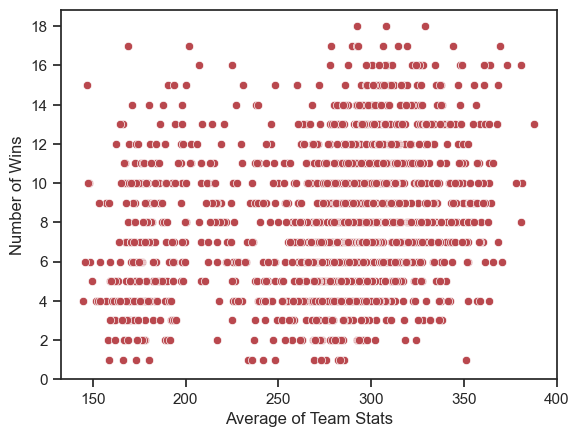

In [22]:
##Code here
pd.pivot_table(matchup_data,values="Team 1",index=["Year","Winner/tie"],aggfunc="count")

table = matchup_data[["Year","Winner/tie","Team 1"]].groupby(["Year","Winner/tie"]).count()

stat_means = []
for (year, team), row in table.iterrows():
  if str(year) + " "+team in team_data_dict:
    numwins = row["Team 1"]
    teamstats = team_data_dict[str(year) + " "+team][1:] #Gets measure of team's stats from dictionary
    stat_means.append([numwins,teamstats.mean(),team])

wins_vs_stats_df = pd.DataFrame(stat_means,columns=["Number of Wins","Average of Team Stats","Team"])

def scatter(df):
  sns.set_theme(style="ticks")
  scatter = sns.scatterplot(data = df,x="Average of Team Stats",y="Number of Wins",color="#b9484e")
  scatter.set(yticks=np.arange(0,19,2))
  plt.show()
scatter(wins_vs_stats_df)

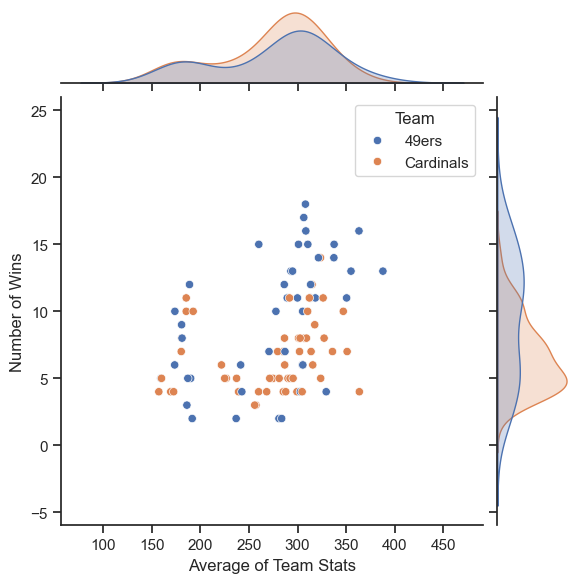

In [23]:
sns.set_theme(style='ticks') # Remove grid to make it look cleaner
scatter_stats = wins_vs_stats_df[(wins_vs_stats_df["Team"] == "49ers")| (wins_vs_stats_df["Team"]=="Cardinals")]
sns.jointplot(data=scatter_stats, x="Average of Team Stats", y="Number of Wins", hue="Team")
plt.savefig(r".\Visualizations\TeamComparison.png")
plt.show()

### Visualization 2: Distribution of 50/50 random chance model vs our model in prediction of Game Winners

Displayed for both current-year-based and previous-year-based model

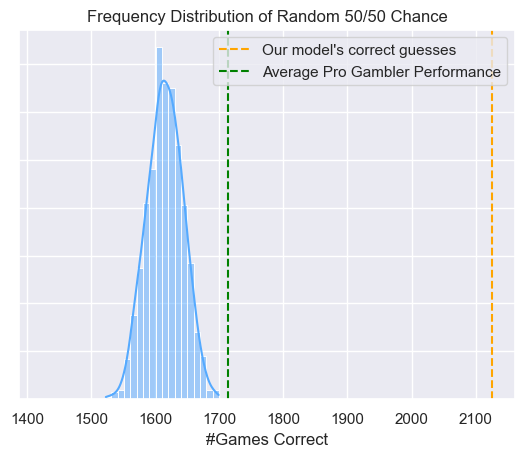

In [28]:
def show_likelihood(effectiveness,ntrials,name,experiments = 1000,filename="img.csv"):
    if name == "Current Year Model":
        bar_color = "#55AAFF"
    else:
        bar_color = "darkorange"
    probabilities = []
    for experiment in range(experiments):
      repetitions = ntrials
      #list comprehension generate ntrials random numbers
      random_integers = [random.randint(0, 1) for _ in range(repetitions)]
      probabilities.append(sum(random_integers))
    sns.set_style("darkgrid")
    hist = sns.histplot(data=probabilities,kde=True,bins=np.linspace(0.44*ntrials,0.59*ntrials,50),color=bar_color)
    plt.axvline(x=effectiveness*ntrials, color="orange", linestyle='--',label="Our model's correct guesses")
    plt.axvline(x=0.53*ntrials,color="green",linestyle="--",label="Average Pro Gambler Performance")
    hist.set(xlabel="#Games Correct",ylabel = "",title="Frequency Distribution of Random 50/50 Chance",yticklabels=[])
    plt.legend(loc="upper right")
    sns.set_context("paper",font_scale = 1.2)
    plt.savefig(filename)
    plt.show()

show_likelihood(effectiveness,len(data_test),"Current Year Model",filename=r".\Visualizations\CurrentYear.png")

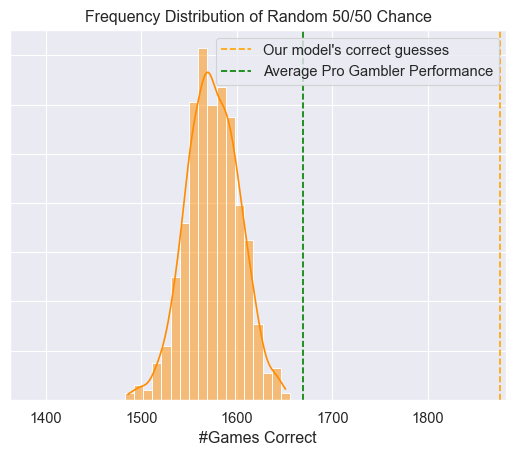

In [25]:
show_likelihood(effectiveness_ly,len(data_test_ly),"Last Year Model",filename=r".\Visualizations\LastYear.png")

### Visualization 4: Top and Bottom 5 Feature Importances to Predict Super Bowl Winners

Could be interpreted as what stats matter most?

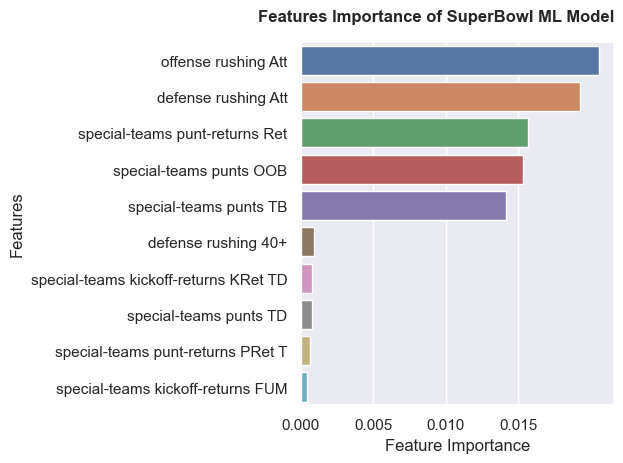

In [27]:
def create_bar_chart(n,df,report_mode = "top and bottom",dark_mode = False):
    sns.set_context("paper")
    top_n = df.nlargest(n,"Importances")
    bottom_n = df.nsmallest(n,"Importances")
    top_and_bottom_n = pd.concat((top_n,bottom_n))


    sns.set_theme()
    if report_mode == "top and bottom":
        report = top_and_bottom_n
    elif report_mode == "top":
        report = top_n
    else:
        report = bottom_n

    report.sort_values("Importances",ascending = False,inplace= True)
    hst = sns.barplot(report,y="Features",hue="Features",x="Importances")
    hst.set(xlabel="Feature Importance",xticks=np.arange(0,0.02,0.005))

    if dark_mode == True:
        hst.tick_params(axis='x', colors='white')
        hst.tick_params(axis='y', colors='white')
        hst.set_xlabel("Feature Importances",color="white")
        # hst.set_ylabel(None)
    plt.title("Features Importance of SuperBowl ML Model",fontdict={"fontweight":"bold"},loc="right",pad=15)
    plt.tight_layout()
    plt.savefig(r".\Visualizations\FeatureImportances.png")
    plt.show()

create_bar_chart(n = 5,df=features_df,report_mode="top and bottom",dark_mode = False)